<a href="https://colab.research.google.com/github/ferdinandre/deepvision/blob/main/milestone3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Vision**

###*Analysis of the ISIC 2024 Dataset Using Computer Vision Techniques*###


*Created by: Ferdinánd André, Barkaszi Richárd Miklós, Cserna Bálint*

##1. Import Kaggle API

In [1]:
import os
from getpass import getpass
import json

# Enter kaggle username and key securely
#kaggle_username = getpass('Enter the username: ')
#kaggle_key = getpass('Enter the key value: ')

# Create the .kaggle directory
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)

# Write the kaggle.json file securely
kaggle_json = {
    "username":"andrferdinnd",
    "key": "3226a556dd21c471fe81d16c0b74adb1"
}

with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as file:
    json.dump(kaggle_json, file)

# Set permissions for the kaggle.json file
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

# Verify that the file is in place (without showing contents)
!ls -l ~/.kaggle/kaggle.json

del file

-rw------- 1 root root 71 Dec 14 19:26 /root/.kaggle/kaggle.json


##2. Load and Unzip Data

In [2]:
# Use Kaggle API to download a dataset
!kaggle competitions download -c isic-2024-challenge

100% 2.00G/2.00G [01:48<00:00, 22.9MB/s]
100% 2.00G/2.00G [01:48<00:00, 19.8MB/s]


In [3]:
# Unzip the dataset
!unzip isic-2024-challenge.zip -d .

A streamkimeneten csak az utolsó 5000 sor látható.
  inflating: ./train-image/image/ISIC_9874656.jpg  
  inflating: ./train-image/image/ISIC_9874659.jpg  
  inflating: ./train-image/image/ISIC_9874663.jpg  
  inflating: ./train-image/image/ISIC_9874742.jpg  
  inflating: ./train-image/image/ISIC_9874751.jpg  
  inflating: ./train-image/image/ISIC_9874803.jpg  
  inflating: ./train-image/image/ISIC_9874805.jpg  
  inflating: ./train-image/image/ISIC_9874832.jpg  
  inflating: ./train-image/image/ISIC_9874878.jpg  
  inflating: ./train-image/image/ISIC_9874897.jpg  
  inflating: ./train-image/image/ISIC_9874925.jpg  
  inflating: ./train-image/image/ISIC_9874931.jpg  
  inflating: ./train-image/image/ISIC_9874939.jpg  
  inflating: ./train-image/image/ISIC_9874940.jpg  
  inflating: ./train-image/image/ISIC_9874963.jpg  
  inflating: ./train-image/image/ISIC_9874987.jpg  
  inflating: ./train-image/image/ISIC_9875007.jpg  
  inflating: ./train-image/image/ISIC_9875010.jpg  
  inflating: 

In [4]:
!sudo rm -rf /content/organized_data/

##3. Preprocess Data

###3.1 Import Libraries and Set random seed

In [5]:
import pandas as pd
import numpy as np
import csv
import os
from PIL import Image
import h5py
!pip install matplotlib
import matplotlib.pyplot as plt
import os
from PIL import Image
import random
import cv2
import glob
# Initializing random seeds
np.random.seed(42)


###3.2 Load Images

In [6]:
# Defining the file paths
train_metadata_path = "/content/train-metadata.csv"
image_path = "/content/train-image/image"

In [7]:
from sklearn.model_selection import train_test_split
import os
import glob
import random

all_images = glob.glob(os.path.join(image_path, "*.jpg")) # Get all images using glob

train_metadata = pd.read_csv(train_metadata_path, low_memory=True) # Get train metadata

# From train metadata take benign and malignant images randomly
benign_images = random.sample(train_metadata[train_metadata["target"] == 0]["isic_id"].tolist(), 2868)
malignant_images = train_metadata[train_metadata["target"] == 1]["isic_id"].tolist()

print(f"Benign images: {len(benign_images)}")
print(f"Malignant images: {len(malignant_images)}")



<ipython-input-7-b6d83518ea5a>:8: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_metadata = pd.read_csv(train_metadata_path, low_memory=True) # Get train metadata


Benign images: 2868
Malignant images: 393


###3.3 Train-Validation-Test Split

In [8]:
# Select exactly 59 benign images for validation and test
benign_temp = random.sample(benign_images, 118)  # 59 for val, 59 for test
benign_val = benign_temp[:59]
benign_test = benign_temp[59:]

# Use the remaining benign images for training
benign_train = list(set(benign_images) - set(benign_temp))  # Remaining benign images
benign_train = random.sample(benign_train, 2750)  # Ensure train has exactly 2750 images

# Split malignant images
malignant_train, malignant_temp = train_test_split(malignant_images, test_size=0.3, random_state=42)
malignant_val, malignant_test = train_test_split(malignant_temp, test_size=0.5, random_state=42)

# Print the results
print(f"Benign - Train: {len(benign_train)}, Val: {len(benign_val)}, Test: {len(benign_test)}")
print(f"Malignant - Train: {len(malignant_train)}, Val: {len(malignant_val)}, Test: {len(malignant_test)}")

Benign - Train: 2750, Val: 59, Test: 59
Malignant - Train: 275, Val: 59, Test: 59


###3.4 Define Subdirectories and Save Images

In [9]:
output_dirs = {   # Define output directories
    "train": "final_train/",
    "val": "final_val/",
    "test": "final_test/"
}

# Create subdirectories for each class
for split in output_dirs:
    for class_name in ['benign', 'malignant']:
        os.makedirs(os.path.join(output_dirs[split], class_name), exist_ok=True)

# Function to resize and save images to the target directory
def resize_and_save(image_list, source_dir, target_dir, target_size=(224, 224)):
    for image_name in image_list:
        # Read the image
        image_path = os.path.join(source_dir, image_name + ".jpg")
        image = cv2.imread(image_path)

        # Resize the image
        resized_image = cv2.resize(image, target_size, interpolation=cv2.INTER_CUBIC)

        # Save the resized image to the target directory
        output_path = os.path.join(target_dir, image_name + ".jpg")
        cv2.imwrite(output_path, resized_image)



###3.5 Image Augmentation

In [10]:
# Function to perform augmentations
def augment_fn(image):
    augmented_images = []
    h, w = image.shape[:2]  # Get image dimensions

    # 1. Horizontal Flip
    flipped = cv2.flip(image, 1)  # Flip horizontally
    augmented_images.append(flipped)

    # 2. Vertical Flip
    flipped_vert = cv2.flip(image, 0)  # Flip vertically
    augmented_images.append(flipped_vert)

    # 3. Rotate 90 degrees clockwise
    rotated_clockwise = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    augmented_images.append(rotated_clockwise)

    # 4. Rotate 90 degrees counterclockwise
    rotated_counterclockwise = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    augmented_images.append(rotated_counterclockwise)

    # 5. Rotate Randomly (between -30 and 30 degrees)
    random_angle = np.random.uniform(-30, 30)
    rotation_matrix_random = cv2.getRotationMatrix2D((w // 2, h // 2), random_angle, 1)
    rotated_random = cv2.warpAffine(image, rotation_matrix_random, (w, h))
    augmented_images.append(rotated_random)

    # 6. Zoom In (110% of original size)
    zoom_factor = 1.1
    zoomed_in = cv2.resize(image, None, fx=zoom_factor, fy=zoom_factor, interpolation=cv2.INTER_LINEAR)
    cropped_zoom_in = zoomed_in[int(h * (zoom_factor - 1) / 2):int(h * (zoom_factor + 1) / 2),
                                int(w * (zoom_factor - 1) / 2):int(w * (zoom_factor + 1) / 2)]
    augmented_images.append(cv2.resize(cropped_zoom_in, (w, h)))  # Resize back to original dimensions

    # 7. Zoom Out (90% of original size)
    zoom_factor = 0.9
    zoomed_out = cv2.resize(image, None, fx=zoom_factor, fy=zoom_factor, interpolation=cv2.INTER_LINEAR)
    padded_zoom_out = cv2.copyMakeBorder(zoomed_out,
                                         top=int(h * (1 - zoom_factor) / 2),
                                         bottom=int(h * (1 - zoom_factor) / 2),
                                         left=int(w * (1 - zoom_factor) / 2),
                                         right=int(w * (1 - zoom_factor) / 2),
                                         borderType=cv2.BORDER_CONSTANT,
                                         value=[0, 0, 0])  # Black padding
    augmented_images.append(cv2.resize(padded_zoom_out, (w, h)))  # Resize back to original dimensions

     # 8. Zoom In (120% of original size)
    zoom_factor_in = 1.2
    zoomed_in = cv2.resize(image, None, fx=zoom_factor_in, fy=zoom_factor_in, interpolation=cv2.INTER_LINEAR)
    cropped_zoom_in = zoomed_in[int(h * (zoom_factor_in - 1) / 2):int(h * (zoom_factor_in + 1) / 2),
                                int(w * (zoom_factor_in - 1) / 2):int(w * (zoom_factor_in + 1) / 2)]
    augmented_images.append(cv2.resize(cropped_zoom_in, (w, h)))  # Resize back to original dimensions

     # 9. Zoom Out (80% of original size)
    zoom_factor_out = 0.8
    zoomed_out = cv2.resize(image, None, fx=zoom_factor_out, fy=zoom_factor_out, interpolation=cv2.INTER_LINEAR)
    padded_zoom_out = cv2.copyMakeBorder(zoomed_out,
                                         top=int(h * (1 - zoom_factor_out) / 2),
                                         bottom=int(h * (1 - zoom_factor_out) / 2),
                                         left=int(w * (1 - zoom_factor_out) / 2),
                                         right=int(w * (1 - zoom_factor_out) / 2),
                                         borderType=cv2.BORDER_CONSTANT,
                                         value=[0, 0, 0])  # Black padding
    augmented_images.append(cv2.resize(padded_zoom_out, (w, h)))  # Resize back to original dimensions

    return augmented_images

###3.6 Resizing and Saving Augmented Images

In [11]:
# Function to augment malignant images
def augment_and_save(image_list, source_dir, target_dir, target_size=(224, 224)):
    augmented = 0
    original=0
    for image_name in image_list:
        original += 1
        # Read the image
        image_path = os.path.join(source_dir, image_name + ".jpg")
        image = cv2.imread(image_path)

        # Resize the image
        resized_image = cv2.resize(image, target_size, interpolation=cv2.INTER_CUBIC)

        # Save the original resized image
        output_path = os.path.join(target_dir, image_name + ".jpg")
        cv2.imwrite(output_path, resized_image)

        # Apply augmentations
        augmentations = augment_fn(resized_image)  # Use your augmentation function here
        for i, aug_img in enumerate(augmentations):
            aug_output_path = os.path.join(target_dir, f"{image_name}_aug_{i}.jpg")
            augmented += 1
            cv2.imwrite(aug_output_path, aug_img)
    print(f"Augmented {augmented} images to {original} original ones.")

In [12]:
# Resize and save benign images
resize_and_save(benign_train, image_path, os.path.join(output_dirs['train'], 'benign'))
resize_and_save(benign_val, image_path, os.path.join(output_dirs['val'], 'benign'))
resize_and_save(benign_test, image_path, os.path.join(output_dirs['test'], 'benign'))

# Resize and augment and save malignant images in training set
augment_and_save(malignant_train, image_path, os.path.join(output_dirs['train'], 'malignant'))

# Resize and save bening val and test
resize_and_save(malignant_val, image_path, os.path.join(output_dirs['val'], 'malignant'))
resize_and_save(malignant_test, image_path, os.path.join(output_dirs['test'], 'malignant'))


print("Images have been organized into train, val, and test directories.")

Augmented 2475 images to 275 original ones.
Images have been organized into train, val, and test directories.


In [14]:
!cd final_train/malignant/ ; ls -l | wc -l  # List the size of directories (It lists +1, so 60-1=59 image in the malignant validation set)
!cd final_train/benign/ ; ls -l | wc -l

!cd final_val/malignant/ ; ls -l | wc -l
!cd final_val/benign/ ; ls -l | wc -l

!cd final_test/malignant/ ; ls -l | wc -l
!cd final_test/benign/ ; ls -l | wc -l

2751
2751
60
60
60
60


###3.7 Define SkinLesionDataset Class

In [ ]:
from torch.utils.data import Dataset, DataLoader

class SkinLesionDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        """
        Args:
            image_dir (str): Path to the directory containing images, organized by class folders.
            transform (callable, optional): Optional transform to apply to the images.
        """
        self.image_dir = image_dir
        self.transform = transform

        # Load all image file paths and their class labels
        self.image_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(image_dir))  # Ensure consistent class ordering

        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(image_dir, class_name)
            for image_name in os.listdir(class_dir):
                self.image_paths.append(os.path.join(class_dir, image_name))
                self.labels.append(float(label))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image and its label
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        # Open image using PIL
        image = Image.open(image_path).convert("RGB")  # Ensure 3 channels (RGB)

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        return image, label

###3.8 Normalization

In [ ]:
from torchvision import transforms

# Define a simple transform
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize with ImageNet stats
                         std=[0.229, 0.224, 0.225])
])


In [ ]:
train_dataset = SkinLesionDataset(image_dir="final_train/", transform=transform)
val_dataset = SkinLesionDataset(image_dir="final_val/", transform=transform)
test_dataset = SkinLesionDataset(image_dir="final_test/", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


In [ ]:
print(f"Number of training samples: {len(train_dataset)}") #Print sample lengths
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 5500
Number of validation samples: 118
Number of test samples: 118


##4. Load the ViT model
####Source: https://huggingface.co/docs/transformers/main/model_doc/vit

In [ ]:
import torch
from transformers import AutoModelForImageClassification
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 4: Load the Pre-Trained ViT Model
model = AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=1,  # Binary classification (benign and malignant)
    ignore_mismatched_sizes=True  # To adjust the classifier head size
)

model.classifier = nn.Sequential(
    nn.Dropout(0.35),  # Dropout with 35%
    nn.Linear(model.classifier.in_features , 1)  # Binary classification (2 classes)
)



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([1]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([1, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(len(model.vit.encoder.layer))  # Number of transformer layers


12


In [ ]:
num_layers_to_freeze = 6
for param in list(model.vit.encoder.layer)[-num_layers_to_freeze:]:
    for p in param.parameters():
        p.requires_grad = False

In [ ]:
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

##5. Define Hyperparameters

In [ ]:
from torch.optim import AdamW
from torch.nn import BCEWithLogitsLoss

no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {"params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
     "weight_decay": 9e-3},
    {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
     "weight_decay": 0.0},
]
optimizer = AdamW(optimizer_grouped_parameters, lr=3e-7)

loss_fn = BCEWithLogitsLoss()

##6. Create the Training and Validation functions

In [ ]:
import torch

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        # Move data to the device
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)

        logits = outputs.logits.squeeze()
        loss = criterion(logits, labels)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate metrics
        running_loss += loss.item()
        probs = torch.sigmoid(outputs.logits.squeeze())  # Apply sigmoid to get probabilities
        preds = (probs > 0.5).long()  # Convert probabilities to binary predictions
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    # Compute average loss and accuracy
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    return epoch_loss, epoch_accuracy


In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define the scheduler
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.25, patience=2, verbose=True)

In [ ]:
def validate(model, val_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        for images, labels in val_loader:
            # Move data to the device
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            logits = outputs.logits.squeeze()
            loss = criterion(logits, labels)

            # Accumulate metrics
            running_loss += loss.item()
            probs = torch.sigmoid(outputs.logits.squeeze())
            preds = (probs > 0.5).long()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    # Compute average loss and accuracy
    val_loss = running_loss / len(val_loader)
    val_accuracy = correct / total
    return val_loss, val_accuracy


In [ ]:
num_epochs = 20

val_losses = []   #Parameters
train_losses = []
val_accuracies = []
train_accuracies = []
patience = 3
best_val_loss = float("inf")
epochs_no_improve = 0




##7. Run the Model

In [ ]:

for epoch in range(num_epochs):  # Adjust number of epochs as needed
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Training step
    train_loss, train_accuracy = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Validation step
    val_loss, val_accuracy = validate(model, val_loader, loss_fn, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    scheduler.step(val_loss)
    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered!")



Epoch 1/20
Train Loss: 0.3918, Train Accuracy: 0.8476
Validation Loss: 0.4700, Validation Accuracy: 0.7542
Epoch 2/20
Train Loss: 0.3759, Train Accuracy: 0.8524
Validation Loss: 0.4581, Validation Accuracy: 0.7542
Epoch 3/20
Train Loss: 0.3590, Train Accuracy: 0.8622
Validation Loss: 0.4564, Validation Accuracy: 0.7458
Epoch 4/20
Train Loss: 0.3403, Train Accuracy: 0.8727
Validation Loss: 0.4394, Validation Accuracy: 0.7542
Epoch 5/20
Train Loss: 0.3327, Train Accuracy: 0.8767
Validation Loss: 0.4365, Validation Accuracy: 0.7542
Epoch 6/20
Train Loss: 0.3195, Train Accuracy: 0.8818
Validation Loss: 0.4296, Validation Accuracy: 0.7627
Epoch 7/20
Train Loss: 0.3088, Train Accuracy: 0.8885
Validation Loss: 0.4252, Validation Accuracy: 0.7627
Epoch 8/20
Train Loss: 0.2977, Train Accuracy: 0.8927
Validation Loss: 0.4268, Validation Accuracy: 0.7712
Epoch 9/20
Train Loss: 0.2905, Train Accuracy: 0.8985
Validation Loss: 0.4155, Validation Accuracy: 0.7627
Epoch 10/20
Train Loss: 0.2805, Train

KeyboardInterrupt: 

##8. Plot Training and Validation Loss and Accuracy

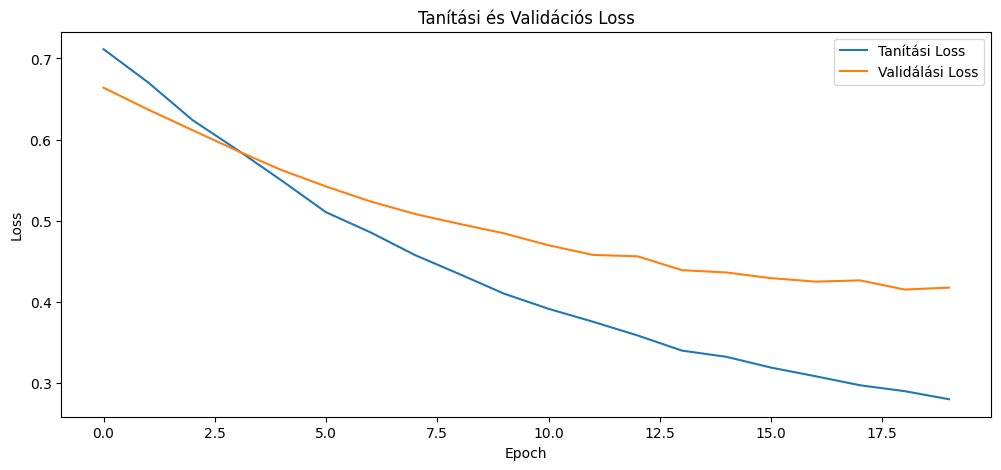

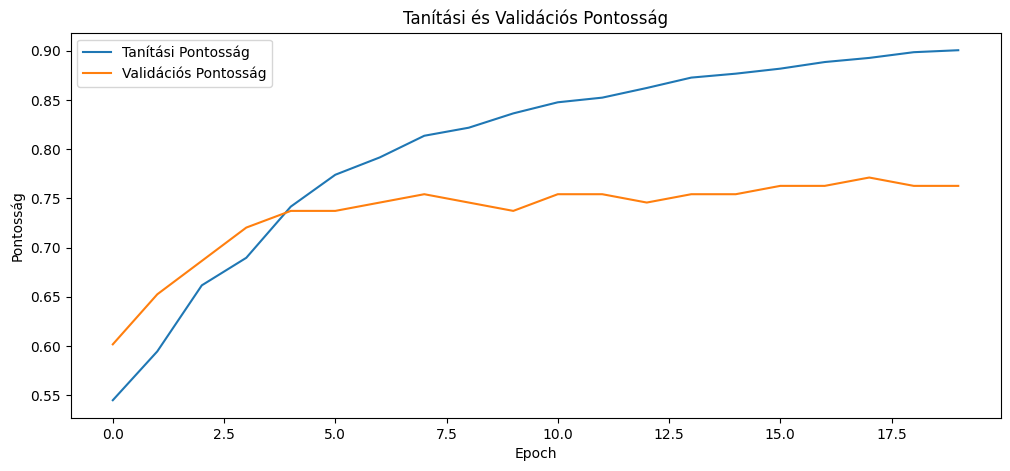

In [ ]:
import matplotlib.pyplot as plt
# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.plot(train_losses, label='Tanítási Loss')
plt.plot(val_losses, label='Validálási Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Tanítási és Validációs Loss')
plt.legend()

plt.show()
plt.close()

# Plot training and validation accuracy
plt.figure(figsize=(12, 5))
plt.plot(train_accuracies, label='Tanítási Pontosság')
plt.plot(val_accuracies, label='Validációs Pontosság')
plt.xlabel('Epoch')
plt.ylabel('Pontosság')
plt.title('Tanítási és Validációs Pontosság')
plt.legend()

plt.show()

In [ ]:
test_loss, test_accuracy = validate(model, test_loader, loss_fn, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.5036, Test Accuracy: 0.8051


##9. Evaluation

In [ ]:
def evaluate_with_threshold(model, test_loader, device, threshold=0.5):
    model.eval()  # Set model to evaluation mode
    true_labels = []
    predicted_labels = []

    with torch.no_grad():  # Disable gradient computation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass to get the logits
            outputs = model(images).logits.squeeze()  # Output shape: [batch_size]
            probs = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities

            # Apply custom threshold to convert probabilities to binary predictions
            preds = (probs > threshold).long()  # Convert probabilities to 0 or 1

            # Store true labels and predicted labels
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())

    return true_labels, predicted_labels


###9.1 Evaluation with Confusion Matrix and Other Metrics

In [ ]:
from sklearn.metrics import confusion_matrix

# Get true and predicted labels
true_labels, predicted_labels = evaluate_with_threshold(model, test_loader, device, threshold=0.4)  # We manually adjust the threshold here

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[46 13]
 [12 47]]


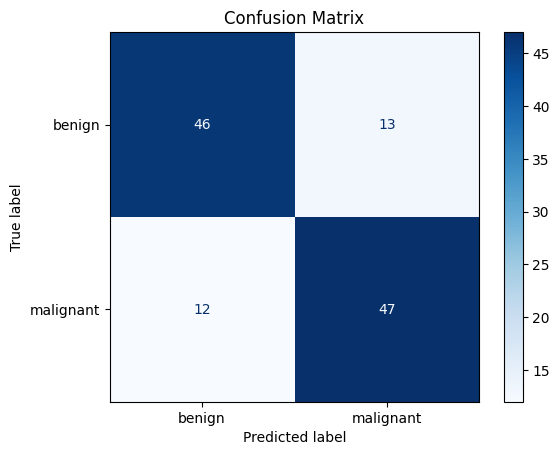

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
# Class names for your labels (e.g., ['benign', 'malignant'])
class_names = ['benign', 'malignant']

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Print classification metrics
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

      benign       0.79      0.78      0.79        59
   malignant       0.78      0.80      0.79        59

    accuracy                           0.79       118
   macro avg       0.79      0.79      0.79       118
weighted avg       0.79      0.79      0.79       118



###9.2 Evaluation with the ROC-AUC Curve

In [ ]:
from sklearn.metrics import roc_curve, auc
import torch

def get_predictions_and_probabilities(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    true_labels = []
    predicted_probs = []

    with torch.no_grad():  # Disable gradient computation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass to get logits
            outputs = model(images).logits.squeeze()  # Remove extra dimensions
            probs = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities

            # Store true labels and probabilities for the positive class
            true_labels.extend(labels.cpu().numpy())
            predicted_probs.extend(probs.cpu().numpy())

    return true_labels, predicted_probs


In [ ]:
# Get true labels and predicted probabilities
true_labels, predicted_probs = get_predictions_and_probabilities(model, test_loader, device)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
roc_auc = auc(fpr, tpr)

print(f"AUC: {roc_auc:.4f}")


AUC: 0.8475


####9.3 Plot The ROC-AUC Curve

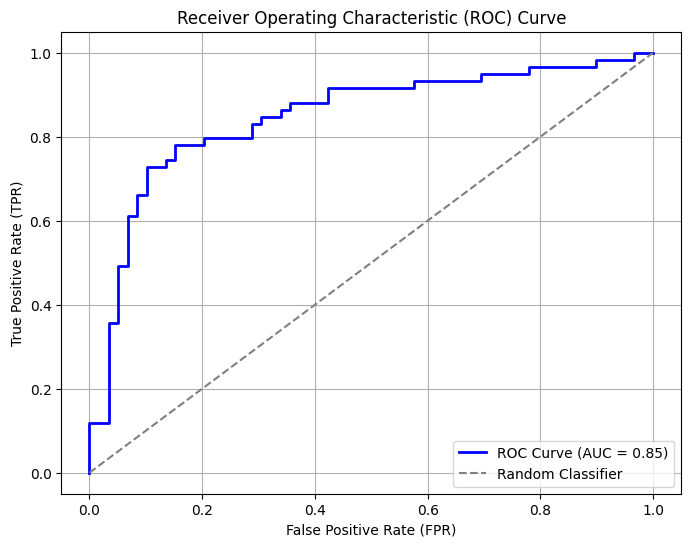

In [ ]:
import matplotlib.pyplot as plt

def plot_roc_curve(fpr, tpr, roc_auc):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')  # Diagonal line
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

# Plot the ROC curve
plot_roc_curve(fpr, tpr, roc_auc)
